# Phase 1: Exploratory Data Analysis

This notebook provides a comprehensive exploratory data analysis of the Telco Customer Churn dataset, focusing on:

1. **Churn Ratios**: Overall churn rate and churn rates by various customer segments
2. **Categorical Breakdowns**: Analysis of how different categorical features relate to churn
3. **Tenure Trends**: Distribution of customer tenure and its relationship with churn
4. **Charges Trends**: Analysis of MonthlyCharges and TotalCharges in relation to churn

## Objectives
- Understand the dataset structure and quality
- Identify key factors associated with customer churn
- Generate insights to inform feature engineering and modeling strategies


In [1]:
import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load data
raw_path = PROJECT_ROOT / "data" / "raw" / "telco_data_28_11_2025.csv"
df = pd.read_csv(raw_path)

# Clean data (matching ingestion pipeline)
df.columns = [c.strip() for c in df.columns]
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["SeniorCitizen"] = df["SeniorCitizen"].astype("Int64")
df = df.dropna(subset=["customerID"])
df["customerID"] = df["customerID"].str.strip()

print(f"Dataset shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}): {list(df.columns)}")
print("\nData types:")
print(df.dtypes.value_counts())
print("\nFirst few rows:")
df.head()


Dataset shape: (7043, 21)

Columns (21): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data types:
object     17
float64     2
Int64       1
int64       1
Name: count, dtype: int64

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


MISSING VALUE ANALYSIS

Columns with missing values:
      Column  Missing Count  Missing Percentage
TotalCharges             11            0.156183


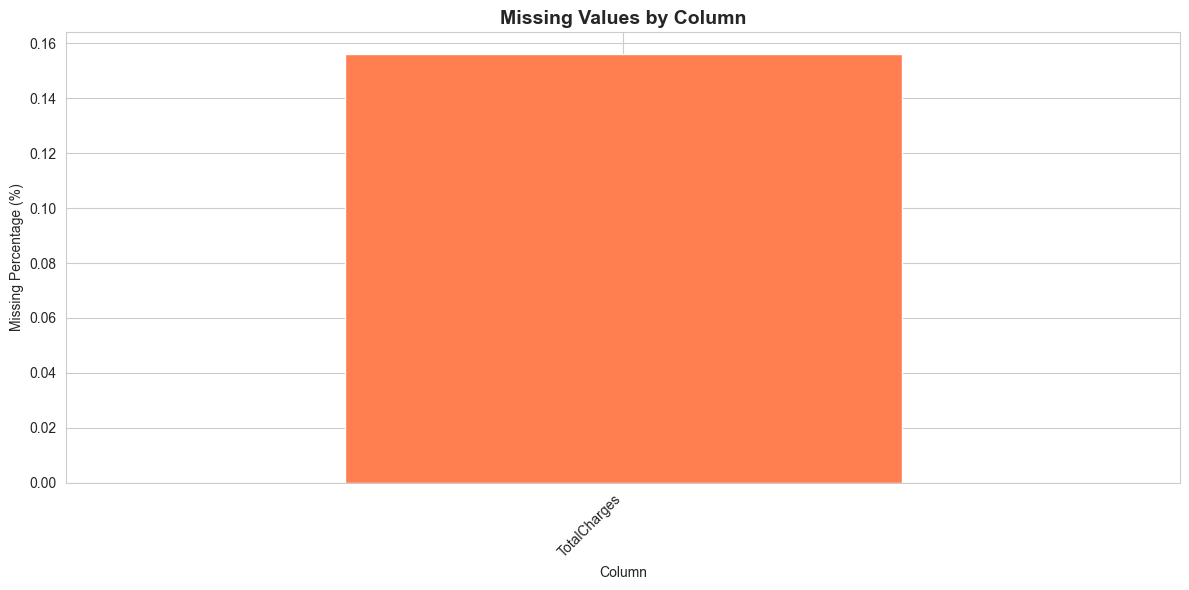


Duplicate rows: 0
Duplicate customer IDs: 0


In [2]:
# Missing value analysis
print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)

missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Percentage': missing_pct.values
}).sort_values('Missing Count', ascending=False)

missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    print(missing_df.to_string(index=False))

    # Visualize missing values
    plt.figure(figsize=(12, 6))
    missing_pct[missing_pct > 0].plot(kind='bar', color='coral')
    plt.title('Missing Values by Column', fontweight='bold', fontsize=14)
    plt.xlabel('Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found in the dataset!")

# Duplicate check
duplicate_count = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count}")

# Check for duplicate customer IDs
duplicate_ids = df['customerID'].duplicated().sum()
print(f"Duplicate customer IDs: {duplicate_ids}")


## 1. Dataset Overview and Churn Distribution

### Initial Data Quality Checks


OVERALL CHURN RATIO
Yes       :  1869 (26.54%)
No        :  5174 (73.46%)


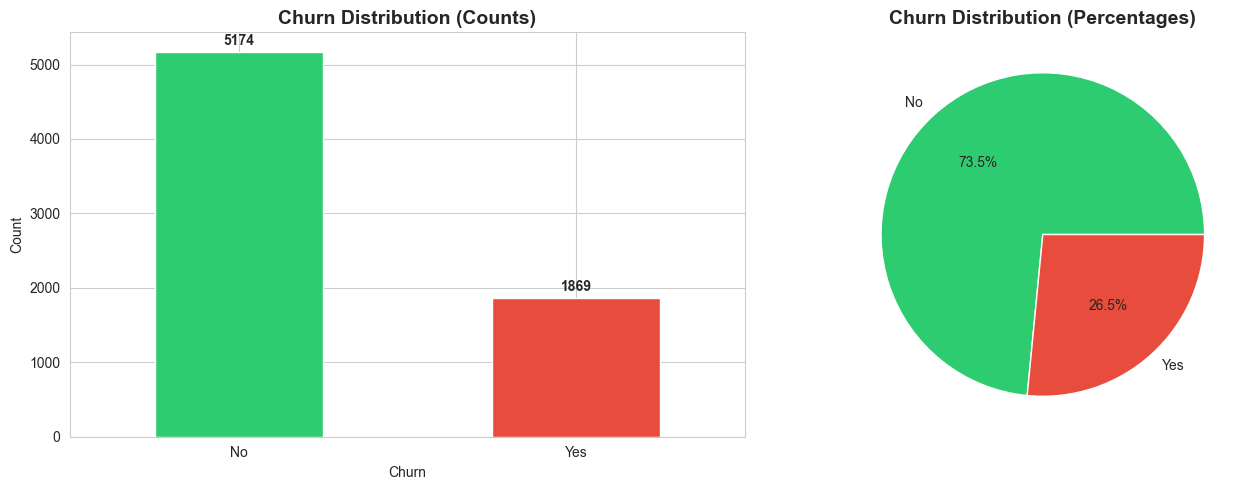


Class Imbalance: 26.5% churn rate indicates imbalanced dataset
   Consider using class weights or resampling techniques in modeling.


In [3]:
# Overall churn ratio
churn_counts = df["Churn"].value_counts()
churn_pct = df["Churn"].value_counts(normalize=True) * 100

print("=" * 50)
print("OVERALL CHURN RATIO")
print("=" * 50)
for label in ["Yes", "No"]:
    print(f"{label:10s}: {churn_counts[label]:5d} ({churn_pct[label]:5.2f}%)")

# Visualize overall churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
churn_counts.plot(kind="bar", ax=axes[0], color=["#2ecc71", "#e74c3c"])
axes[0].set_title("Churn Distribution (Counts)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(["No", "Yes"], rotation=0)
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha="center", va="bottom", fontweight="bold")

# Pie chart
churn_pct.plot(kind="pie", ax=axes[1], autopct="%1.1f%%", colors=["#2ecc71", "#e74c3c"])
axes[1].set_title("Churn Distribution (Percentages)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance: {churn_pct['Yes']:.1f}% churn rate indicates imbalanced dataset")
print("   Consider using class weights or resampling techniques in modeling.")


CHURN RATIOS BY CATEGORICAL FEATURES

GENDER:
Churn      No    Yes
gender              
Female  73.08  26.92
Male    73.84  26.16
  Churn Rate (Yes): 26.54%

SENIORCITIZEN:
Churn             No    Yes
SeniorCitizen              
No             76.39  23.61
Yes            58.32  41.68
  Churn Rate (Yes): 32.64%

PARTNER:
Churn       No    Yes
Partner              
No       67.04  32.96
Yes      80.34  19.66
  Churn Rate (Yes): 26.31%

DEPENDENTS:
Churn          No    Yes
Dependents              
No          68.72  31.28
Yes         84.55  15.45
  Churn Rate (Yes): 23.36%

PHONESERVICE:
Churn            No    Yes
PhoneService              
No            75.07  24.93
Yes           73.29  26.71
  Churn Rate (Yes): 25.82%

INTERNETSERVICE:
Churn               No    Yes
InternetService              
DSL              81.04  18.96
Fiber optic      58.11  41.89
No               92.60   7.40
  Churn Rate (Yes): 22.75%

CONTRACT:
Churn              No    Yes
Contract                    
Month-to-

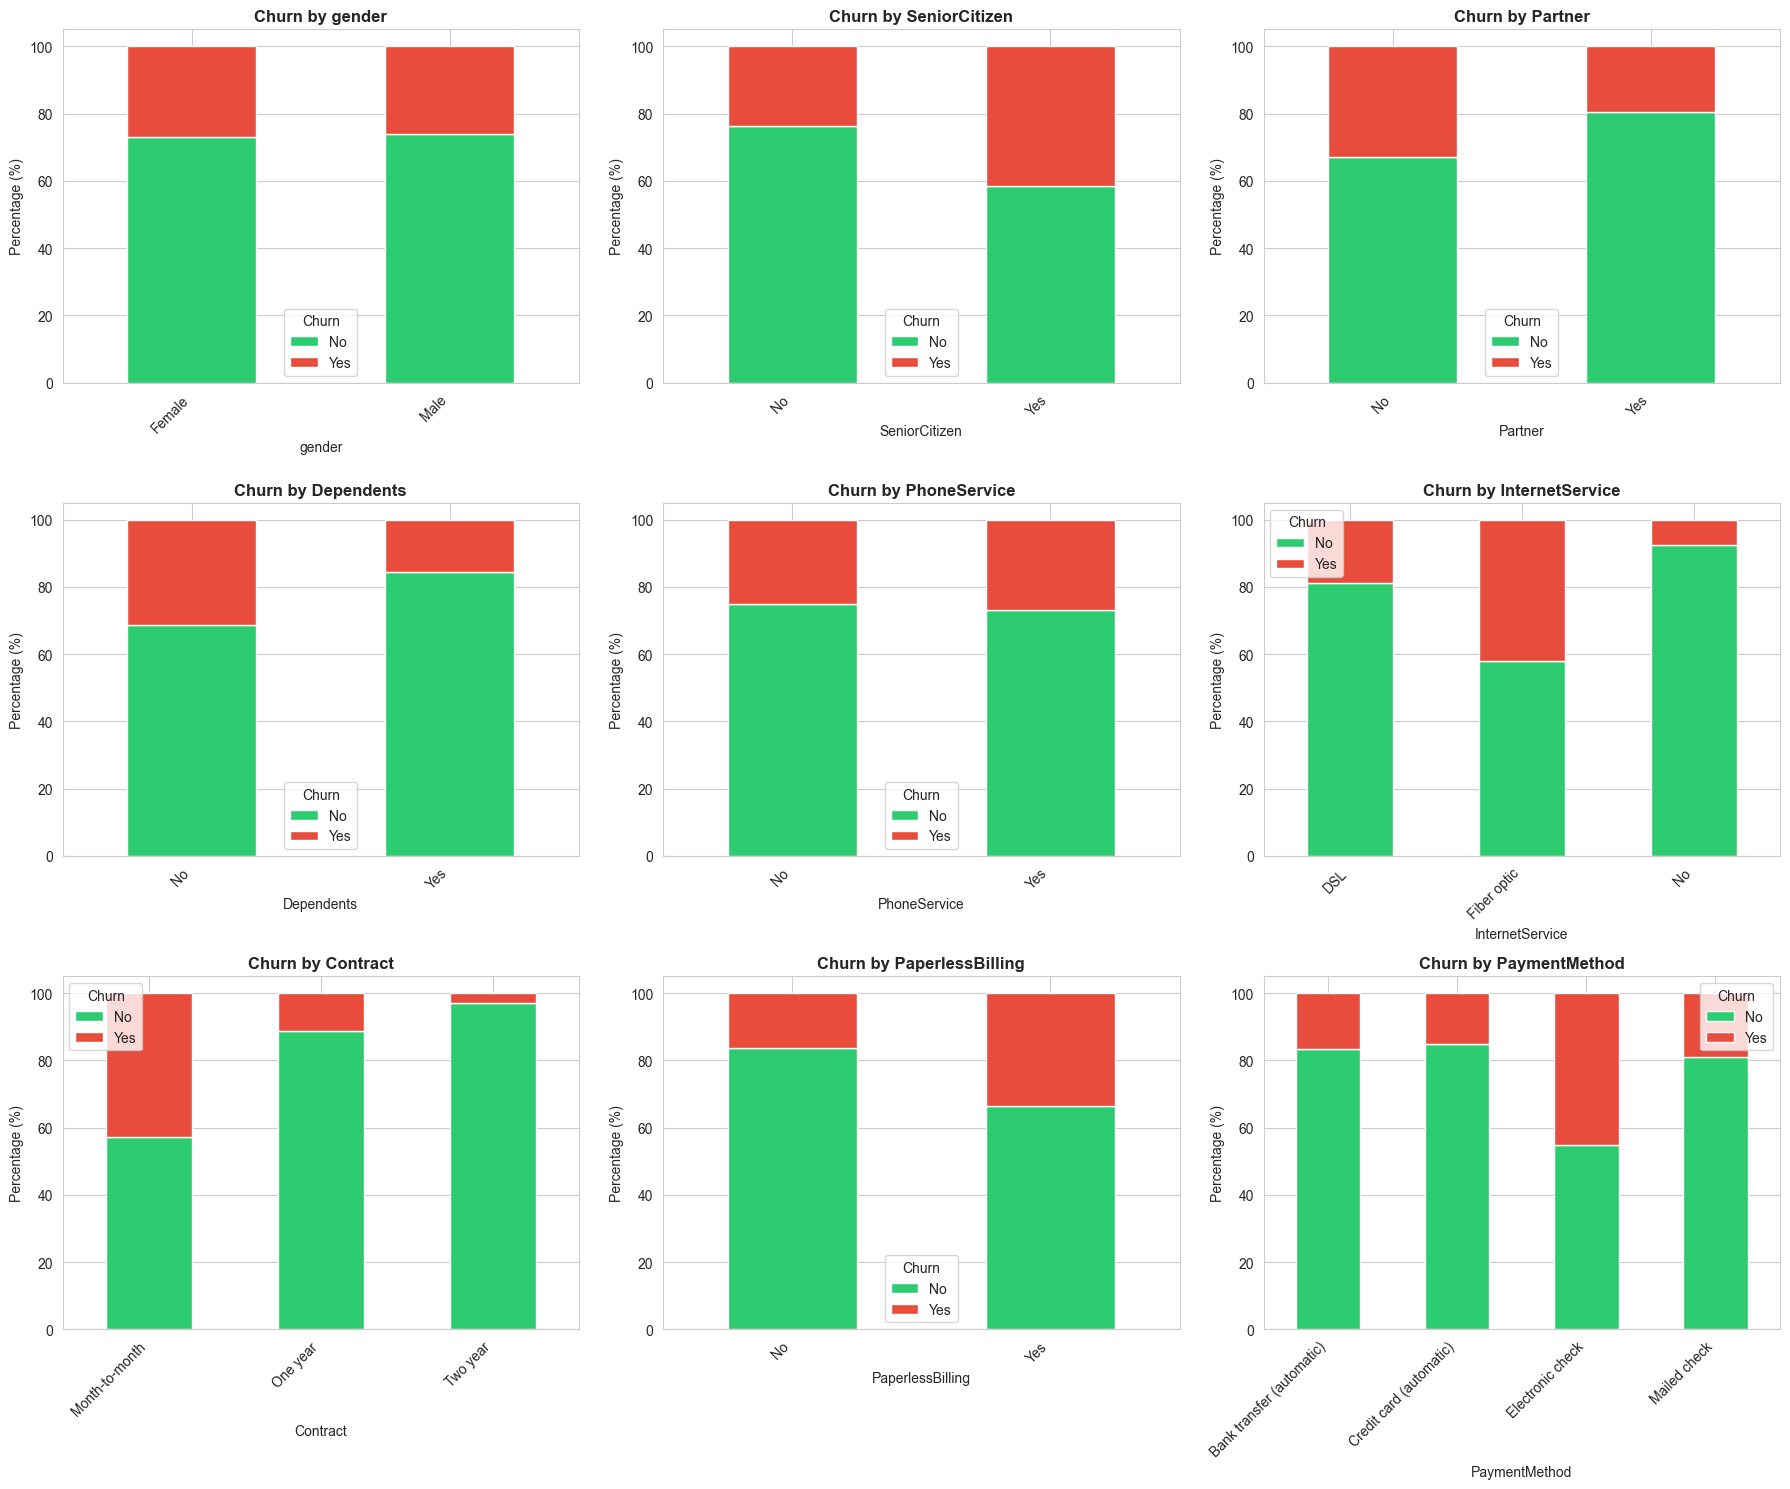

In [4]:
# Churn ratios by key categorical features
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "InternetService",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

print("=" * 80)
print("CHURN RATIOS BY CATEGORICAL FEATURES")
print("=" * 80)

churn_by_cat = {}
for feature in categorical_features:
    if feature == "SeniorCitizen":
        # Convert to string for consistency
        df_temp = df.copy()
        df_temp[feature] = df_temp[feature].astype(str).replace({"0": "No", "1": "Yes"})
    else:
        df_temp = df

    crosstab = pd.crosstab(df_temp[feature], df["Churn"], normalize="index") * 100
    churn_by_cat[feature] = crosstab

    print(f"\n{feature.upper()}:")
    print(crosstab.round(2))
    print(f"  Churn Rate (Yes): {crosstab['Yes'].mean():.2f}%")

# Visualize churn rates by key features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features[:9]):
    if feature == "SeniorCitizen":
        df_temp = df.copy()
        df_temp[feature] = df_temp[feature].astype(str).replace({"0": "No", "1": "Yes"})
    else:
        df_temp = df

    crosstab = pd.crosstab(df_temp[feature], df["Churn"])
    crosstab_pct = pd.crosstab(df_temp[feature], df["Churn"], normalize="index") * 100

    crosstab_pct.plot(kind="bar", ax=axes[idx], color=["#2ecc71", "#e74c3c"], stacked=True)
    axes[idx].set_title(f"Churn by {feature}", fontweight="bold")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend(title="Churn", labels=["No", "Yes"])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


## 2. Categorical Breakdowns

Detailed analysis of how categorical features relate to churn, including service combinations.


CHURN RATIOS BY SERVICE FEATURES

OnlineSecurity:
  Churn Rate by Category:
    No                  : 41.77%
    No internet service :  7.40%
    Yes                 : 14.61%

OnlineBackup:
  Churn Rate by Category:
    No                  : 39.93%
    No internet service :  7.40%
    Yes                 : 21.53%

DeviceProtection:
  Churn Rate by Category:
    No                  : 39.13%
    No internet service :  7.40%
    Yes                 : 22.50%

TechSupport:
  Churn Rate by Category:
    No                  : 41.64%
    No internet service :  7.40%
    Yes                 : 15.17%

StreamingTV:
  Churn Rate by Category:
    No                  : 33.52%
    No internet service :  7.40%
    Yes                 : 30.07%

StreamingMovies:
  Churn Rate by Category:
    No                  : 33.68%
    No internet service :  7.40%
    Yes                 : 29.94%


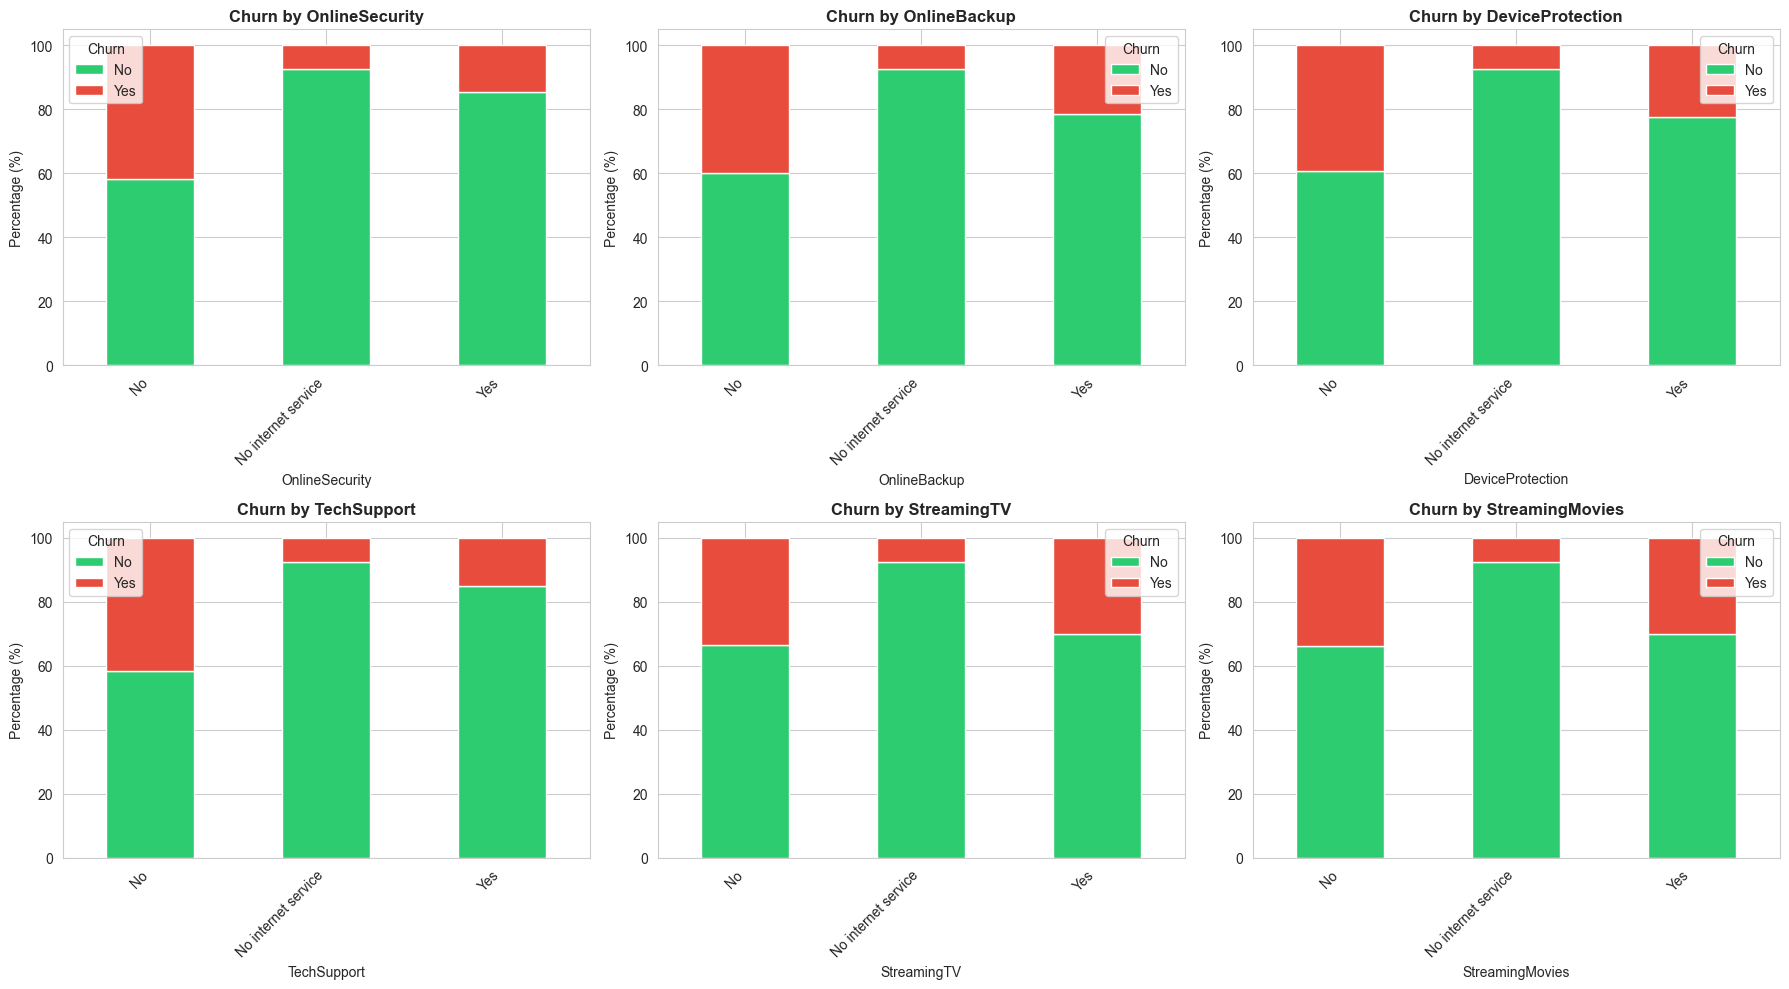

In [5]:
# Service combinations analysis
service_features = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

print("=" * 80)
print("CHURN RATIOS BY SERVICE FEATURES")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(service_features):
    crosstab_pct = pd.crosstab(df[feature], df["Churn"], normalize="index") * 100

    crosstab_pct.plot(kind="bar", ax=axes[idx], color=["#2ecc71", "#e74c3c"], stacked=True)
    axes[idx].set_title(f"Churn by {feature}", fontweight="bold")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend(title="Churn", labels=["No", "Yes"])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right")

    # Print summary
    print(f"\n{feature}:")
    print("  Churn Rate by Category:")
    for category in crosstab_pct.index:
        churn_rate = crosstab_pct.loc[category, "Yes"]
        print(f"    {category:20s}: {churn_rate:5.2f}%")

plt.tight_layout()
plt.show()


KEY INSIGHTS: CONTRACT & PAYMENT METHOD

Contract Type Churn Rates:
Churn              No    Yes
Contract                    
Month-to-month  57.29  42.71
One year        88.73  11.27
Two year        97.17   2.83

Payment Method Churn Rates:
Churn                         No    Yes
PaymentMethod                          
Bank transfer (automatic)  83.29  16.71
Credit card (automatic)    84.76  15.24
Electronic check           54.71  45.29
Mailed check               80.89  19.11


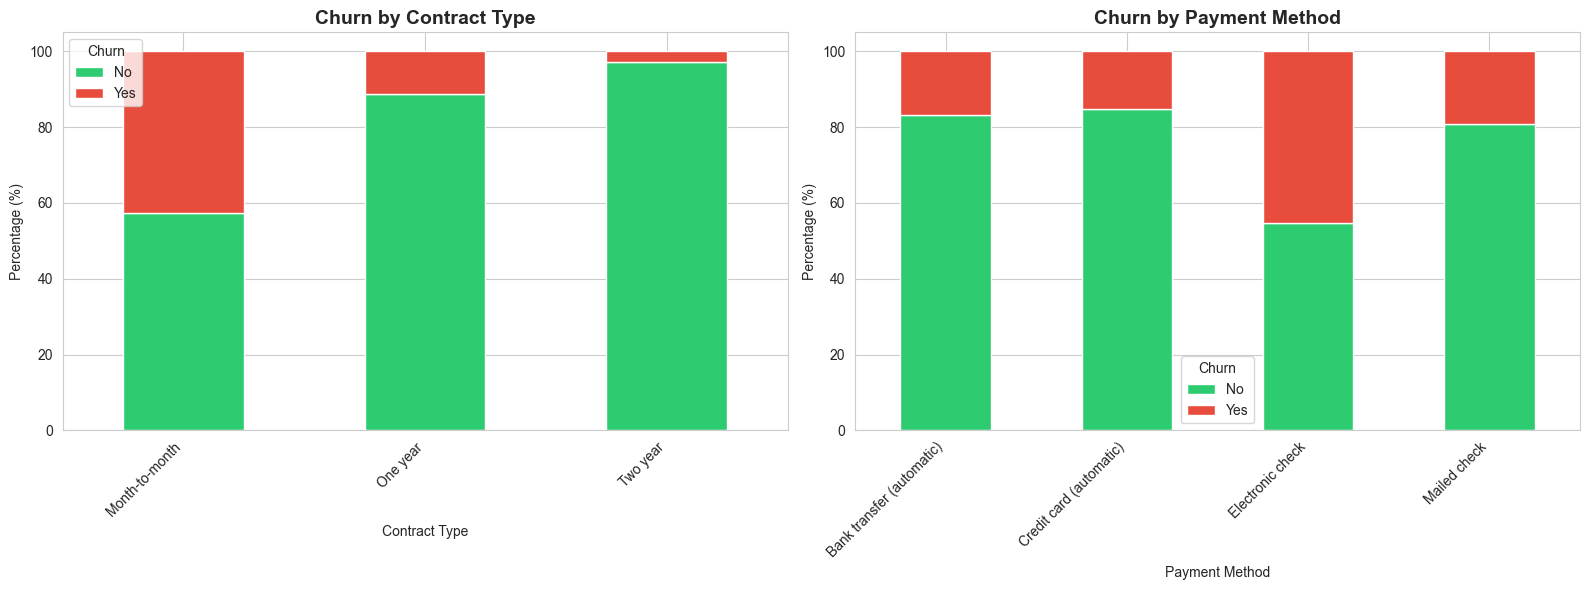


Key Finding: Month-to-month contracts and Electronic check payments show highest churn rates!


In [6]:
# Contract and Payment Method - Key drivers
print("=" * 80)
print("KEY INSIGHTS: CONTRACT & PAYMENT METHOD")
print("=" * 80)

# Contract analysis
contract_churn = pd.crosstab(df["Contract"], df["Churn"], normalize="index") * 100
print("\nContract Type Churn Rates:")
print(contract_churn.round(2))

# Payment Method analysis
payment_churn = pd.crosstab(df["PaymentMethod"], df["Churn"], normalize="index") * 100
print("\nPayment Method Churn Rates:")
print(payment_churn.round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

contract_churn.plot(kind="bar", ax=axes[0], color=["#2ecc71", "#e74c3c"], stacked=True)
axes[0].set_title("Churn by Contract Type", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Contract Type")
axes[0].set_ylabel("Percentage (%)")
axes[0].legend(title="Churn", labels=["No", "Yes"])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

payment_churn.plot(kind="bar", ax=axes[1], color=["#2ecc71", "#e74c3c"], stacked=True)
axes[1].set_title("Churn by Payment Method", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Payment Method")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(title="Churn", labels=["No", "Yes"])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

print("\nKey Finding: Month-to-month contracts and Electronic check payments show highest churn rates!")


## 3. Tenure Trends

Analysis of customer tenure distribution and its relationship with churn.


TENURE ANALYSIS

Tenure Statistics:
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


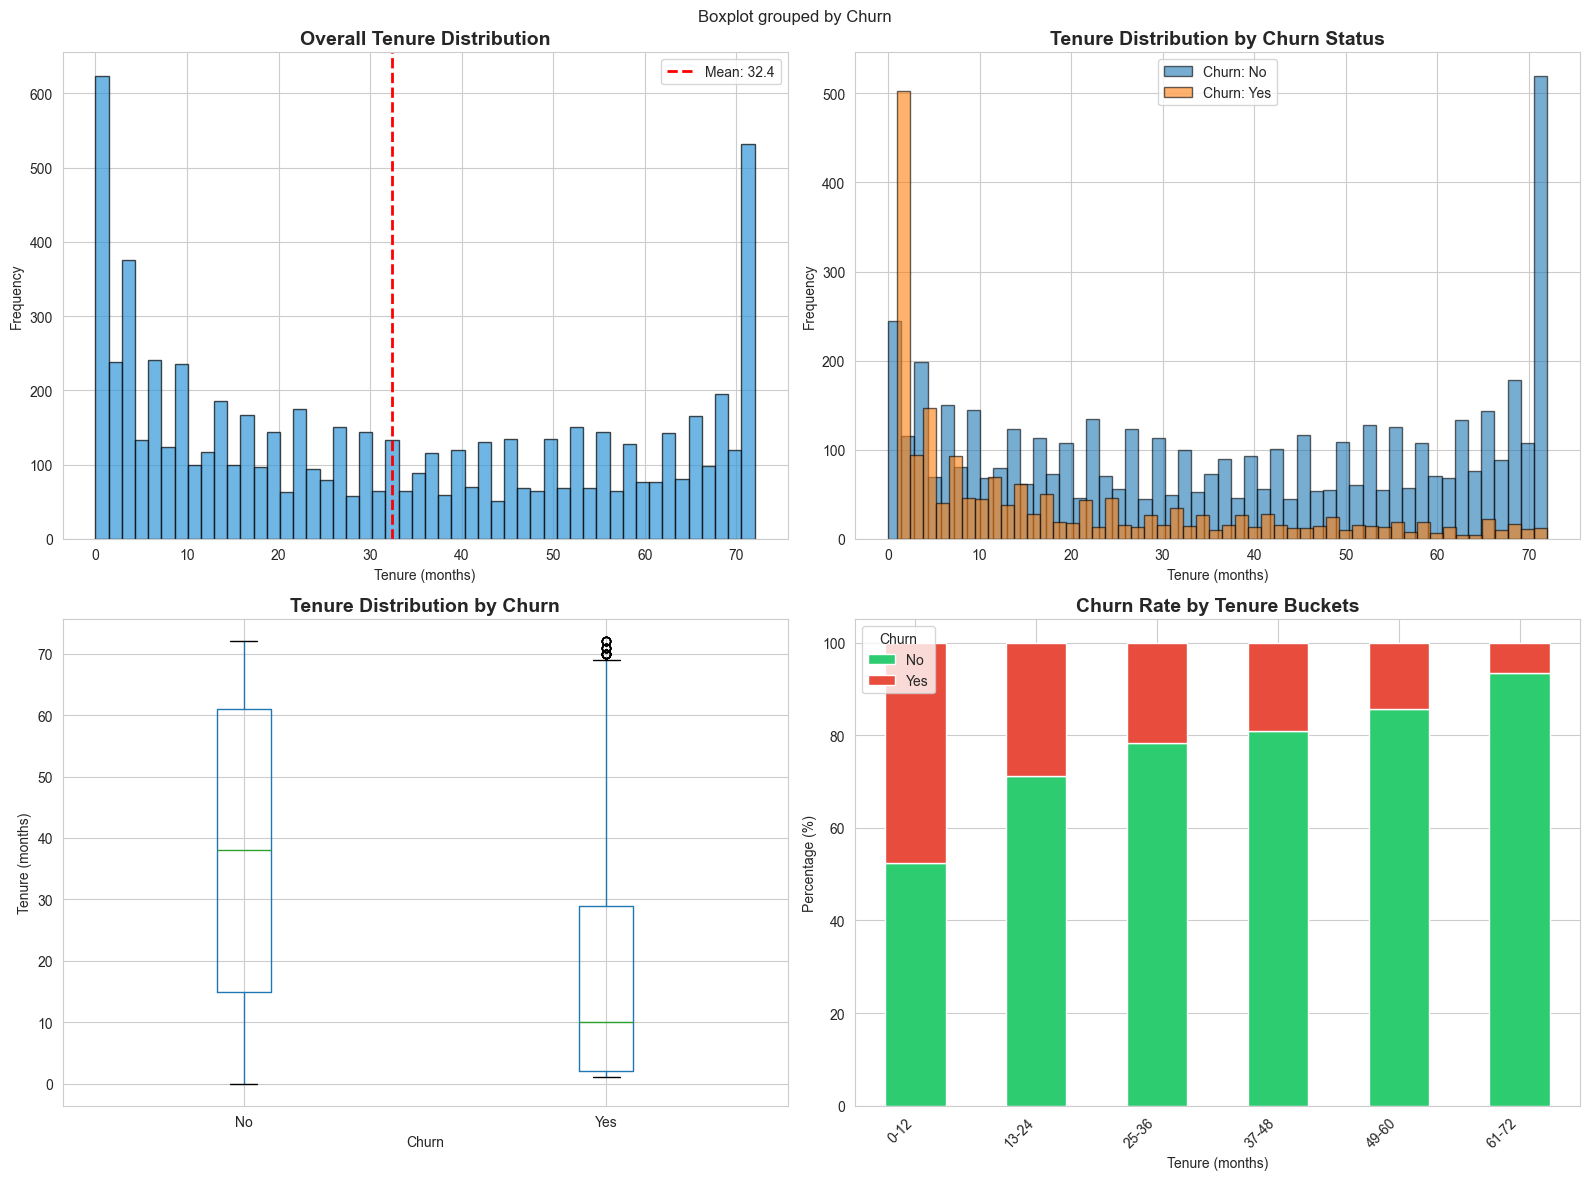


Tenure Statistics by Churn Status:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

Key Finding: Customers with shorter tenure (< 12 months) have significantly higher churn rates!


In [7]:
# Tenure distribution
print("=" * 80)
print("TENURE ANALYSIS")
print("=" * 80)

print("\nTenure Statistics:")
print(df["tenure"].describe())

# Tenure distribution by churn
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall tenure distribution
axes[0, 0].hist(df["tenure"], bins=50, color="#3498db", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Overall Tenure Distribution", fontweight="bold", fontsize=14)
axes[0, 0].set_xlabel("Tenure (months)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(df["tenure"].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {df['tenure'].mean():.1f}")
axes[0, 0].legend()

# Tenure by churn status
for churn_status in ["No", "Yes"]:
    tenure_data = df[df["Churn"] == churn_status]["tenure"]
    axes[0, 1].hist(tenure_data, bins=50, alpha=0.6, label=f"Churn: {churn_status}", edgecolor="black")
axes[0, 1].set_title("Tenure Distribution by Churn Status", fontweight="bold", fontsize=14)
axes[0, 1].set_xlabel("Tenure (months)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# Box plot: Tenure by churn
df.boxplot(column="tenure", by="Churn", ax=axes[1, 0])
axes[1, 0].set_title("Tenure Distribution by Churn", fontweight="bold", fontsize=14)
axes[1, 0].set_xlabel("Churn")
axes[1, 0].set_ylabel("Tenure (months)")
axes[1, 0].set_xticklabels(["No", "Yes"])

# Tenure buckets analysis
df["tenure_bucket"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 36, 48, 60, 72, 100],
    labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61-72", "73+"]
)
tenure_bucket_churn = pd.crosstab(df["tenure_bucket"], df["Churn"], normalize="index") * 100
tenure_bucket_churn.plot(kind="bar", ax=axes[1, 1], color=["#2ecc71", "#e74c3c"], stacked=True)
axes[1, 1].set_title("Churn Rate by Tenure Buckets", fontweight="bold", fontsize=14)
axes[1, 1].set_xlabel("Tenure (months)")
axes[1, 1].set_ylabel("Percentage (%)")
axes[1, 1].legend(title="Churn", labels=["No", "Yes"])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTenure Statistics by Churn Status:")
print(df.groupby("Churn")["tenure"].describe())

print("\nKey Finding: Customers with shorter tenure (< 12 months) have significantly higher churn rates!")


## 4. Charges Analysis

Analysis of MonthlyCharges and TotalCharges in relation to churn.


CHARGES ANALYSIS

MonthlyCharges Statistics:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

TotalCharges Statistics (excluding missing):
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


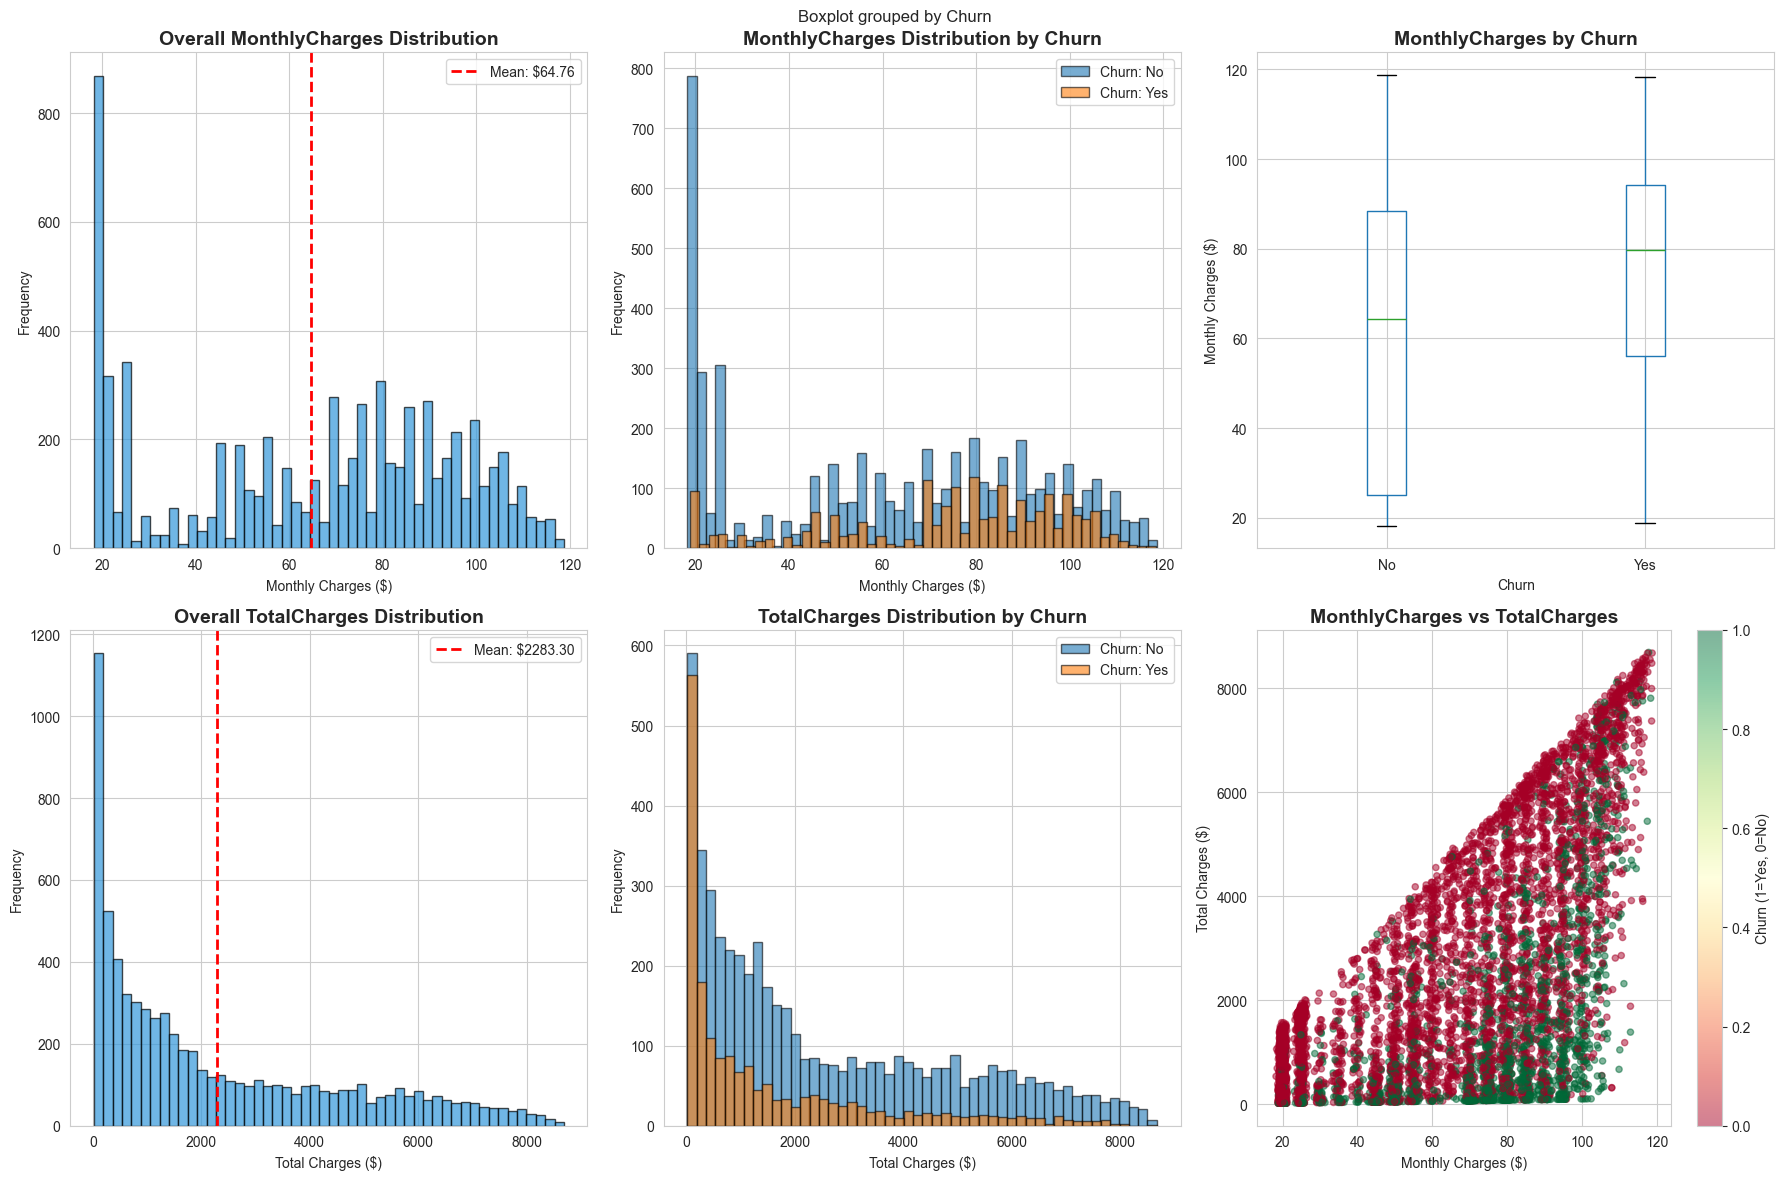


MonthlyCharges Statistics by Churn Status:
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

TotalCharges Statistics by Churn Status:
        count         mean          std    min      25%      50%       75%  \
Churn                                                                        
No     5163.0  2555.344141  2329.456984  18.80  577.825  1683.60  4264.125   
Yes    1869.0  1531.796094  1890.822994  18.85  134.500   703.55  2331.300   

           max  
Churn           
No     8672.45  
Yes    8684.80  

Key Finding: Customers with higher MonthlyCharges tend to churn more, but those with higher TotalCharges (longer tenure) churn less!


In [8]:
# Charges analysis
print("=" * 80)
print("CHARGES ANALYSIS")
print("=" * 80)

print("\nMonthlyCharges Statistics:")
print(df["MonthlyCharges"].describe())

print("\nTotalCharges Statistics (excluding missing):")
print(df["TotalCharges"].dropna().describe())

# Charges distribution by churn
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# MonthlyCharges distribution
axes[0, 0].hist(df["MonthlyCharges"], bins=50, color="#3498db", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Overall MonthlyCharges Distribution", fontweight="bold", fontsize=14)
axes[0, 0].set_xlabel("Monthly Charges ($)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(df["MonthlyCharges"].mean(), color="red", linestyle="--", linewidth=2,
                   label=f"Mean: ${df['MonthlyCharges'].mean():.2f}")
axes[0, 0].legend()

# MonthlyCharges by churn
for churn_status in ["No", "Yes"]:
    charges_data = df[df["Churn"] == churn_status]["MonthlyCharges"]
    axes[0, 1].hist(charges_data, bins=50, alpha=0.6, label=f"Churn: {churn_status}", edgecolor="black")
axes[0, 1].set_title("MonthlyCharges Distribution by Churn", fontweight="bold", fontsize=14)
axes[0, 1].set_xlabel("Monthly Charges ($)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# Box plot: MonthlyCharges by churn
df.boxplot(column="MonthlyCharges", by="Churn", ax=axes[0, 2])
axes[0, 2].set_title("MonthlyCharges by Churn", fontweight="bold", fontsize=14)
axes[0, 2].set_xlabel("Churn")
axes[0, 2].set_ylabel("Monthly Charges ($)")
axes[0, 2].set_xticklabels(["No", "Yes"])

# TotalCharges distribution (excluding missing)
df_clean = df.dropna(subset=["TotalCharges"]).copy()
axes[1, 0].hist(df_clean["TotalCharges"], bins=50, color="#3498db", edgecolor="black", alpha=0.7)
axes[1, 0].set_title("Overall TotalCharges Distribution", fontweight="bold", fontsize=14)
axes[1, 0].set_xlabel("Total Charges ($)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].axvline(df_clean["TotalCharges"].mean(), color="red", linestyle="--", linewidth=2,
                   label=f"Mean: ${df_clean['TotalCharges'].mean():.2f}")
axes[1, 0].legend()

# TotalCharges by churn
for churn_status in ["No", "Yes"]:
    charges_data = df_clean[df_clean["Churn"] == churn_status]["TotalCharges"]
    axes[1, 1].hist(charges_data, bins=50, alpha=0.6, label=f"Churn: {churn_status}", edgecolor="black")
axes[1, 1].set_title("TotalCharges Distribution by Churn", fontweight="bold", fontsize=14)
axes[1, 1].set_xlabel("Total Charges ($)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].legend()

# Scatter: MonthlyCharges vs TotalCharges colored by churn
scatter = axes[1, 2].scatter(
    df_clean["MonthlyCharges"],
    df_clean["TotalCharges"],
    c=df_clean["Churn"].map({"Yes": 1, "No": 0}),
    cmap="RdYlGn",
    alpha=0.5,
    s=20
)
axes[1, 2].set_title("MonthlyCharges vs TotalCharges", fontweight="bold", fontsize=14)
axes[1, 2].set_xlabel("Monthly Charges ($)")
axes[1, 2].set_ylabel("Total Charges ($)")
plt.colorbar(scatter, ax=axes[1, 2], label="Churn (1=Yes, 0=No)")

plt.tight_layout()
plt.show()

# Statistical summary
print("\nMonthlyCharges Statistics by Churn Status:")
print(df.groupby("Churn")["MonthlyCharges"].describe())

print("\nTotalCharges Statistics by Churn Status:")
print(df_clean.groupby("Churn")["TotalCharges"].describe())

print("\nKey Finding: Customers with higher MonthlyCharges tend to churn more, but those with higher TotalCharges (longer tenure) churn less!")


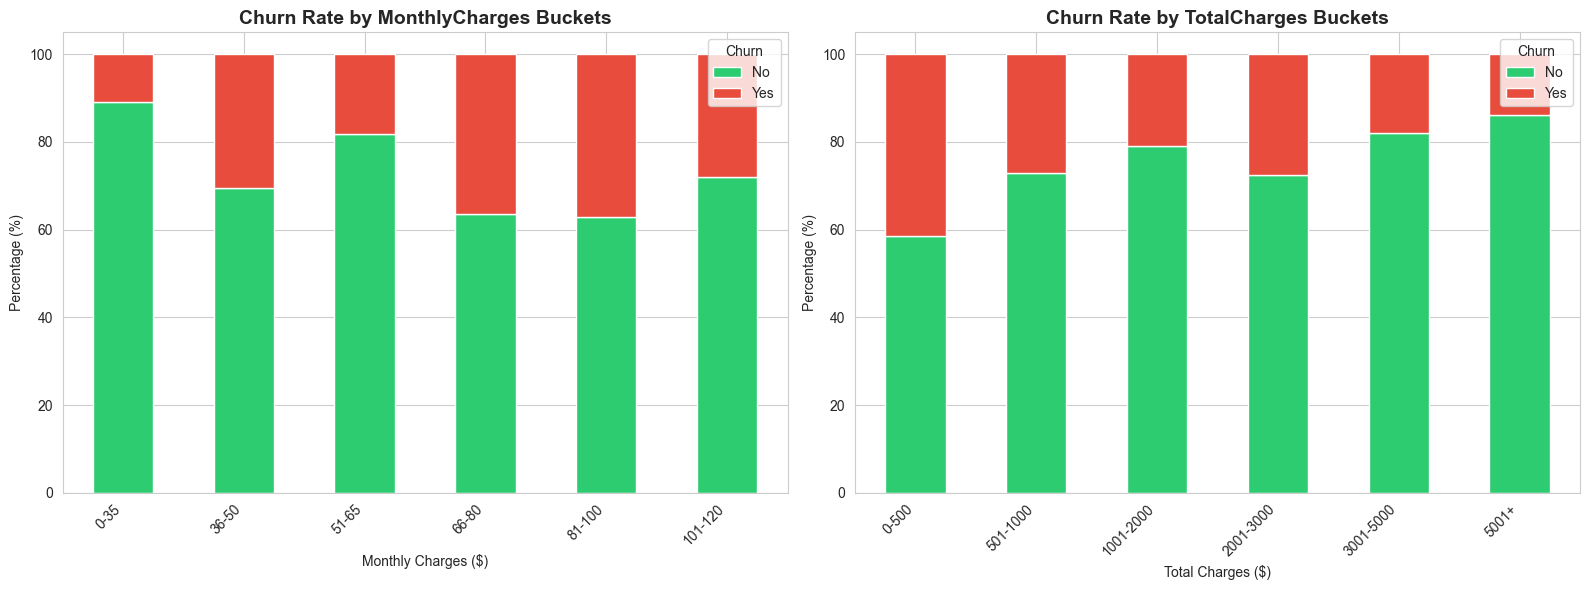


MonthlyCharges Buckets Churn Rates:
Churn                      No    Yes
monthly_charges_bucket              
0-35                    89.11  10.89
36-50                   69.50  30.50
51-65                   81.78  18.22
66-80                   63.67  36.33
81-100                  62.98  37.02
101-120                 71.95  28.05

TotalCharges Buckets Churn Rates:
Churn                    No    Yes
total_charges_bucket              
0-500                 58.55  41.45
501-1000              73.01  26.99
1001-2000             79.03  20.97
2001-3000             72.39  27.61
3001-5000             81.95  18.05
5001+                 86.17  13.83


In [9]:
# Charges buckets analysis
df["monthly_charges_bucket"] = pd.cut(
    df["MonthlyCharges"],
    bins=[0, 35, 50, 65, 80, 100, 120],
    labels=["0-35", "36-50", "51-65", "66-80", "81-100", "101-120"]
)

df_clean["total_charges_bucket"] = pd.cut(
    df_clean["TotalCharges"],
    bins=[0, 500, 1000, 2000, 3000, 5000, 10000],
    labels=["0-500", "501-1000", "1001-2000", "2001-3000", "3001-5000", "5001+"]
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MonthlyCharges buckets
monthly_bucket_churn = pd.crosstab(df["monthly_charges_bucket"], df["Churn"], normalize="index") * 100
monthly_bucket_churn.plot(kind="bar", ax=axes[0], color=["#2ecc71", "#e74c3c"], stacked=True)
axes[0].set_title("Churn Rate by MonthlyCharges Buckets", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Monthly Charges ($)")
axes[0].set_ylabel("Percentage (%)")
axes[0].legend(title="Churn", labels=["No", "Yes"])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# TotalCharges buckets
total_bucket_churn = pd.crosstab(df_clean["total_charges_bucket"], df_clean["Churn"], normalize="index") * 100
total_bucket_churn.plot(kind="bar", ax=axes[1], color=["#2ecc71", "#e74c3c"], stacked=True)
axes[1].set_title("Churn Rate by TotalCharges Buckets", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Total Charges ($)")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(title="Churn", labels=["No", "Yes"])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

print("\nMonthlyCharges Buckets Churn Rates:")
print(monthly_bucket_churn.round(2))

print("\nTotalCharges Buckets Churn Rates:")
print(total_bucket_churn.round(2))


## 5. Outlier Detection

Identify potential outliers in numeric features that may need special handling.

### Top Churn Risk Factors:
1. **Contract Type**: Month-to-month contracts have the highest churn rate
2. **Payment Method**: Electronic check payments show elevated churn
3. **Tenure**: New customers (< 12 months) are at highest risk
4. **Monthly Charges**: Higher monthly charges correlate with increased churn
5. **Services**: Customers without add-on services (OnlineSecurity, TechSupport) churn more

### Recommendations for Feature Engineering:
- Create tenure buckets (0-12, 13-24, 25-36, etc.)
- Create charges ratio features (MonthlyCharges/TotalCharges)
- Create service count features (number of add-on services)
- Create contract-payment interaction features
- Consider creating customer lifetime value proxy (TotalCharges / tenure)


OUTLIER DETECTION (IQR Method)

tenure:
  Outliers: 0 (0.00%)
  Bounds: [-60.00, 124.00]

MonthlyCharges:
  Outliers: 0 (0.00%)
  Bounds: [-46.02, 171.38]

TotalCharges:
  Outliers: 0 (0.00%)
  Bounds: [-4688.48, 8884.67]


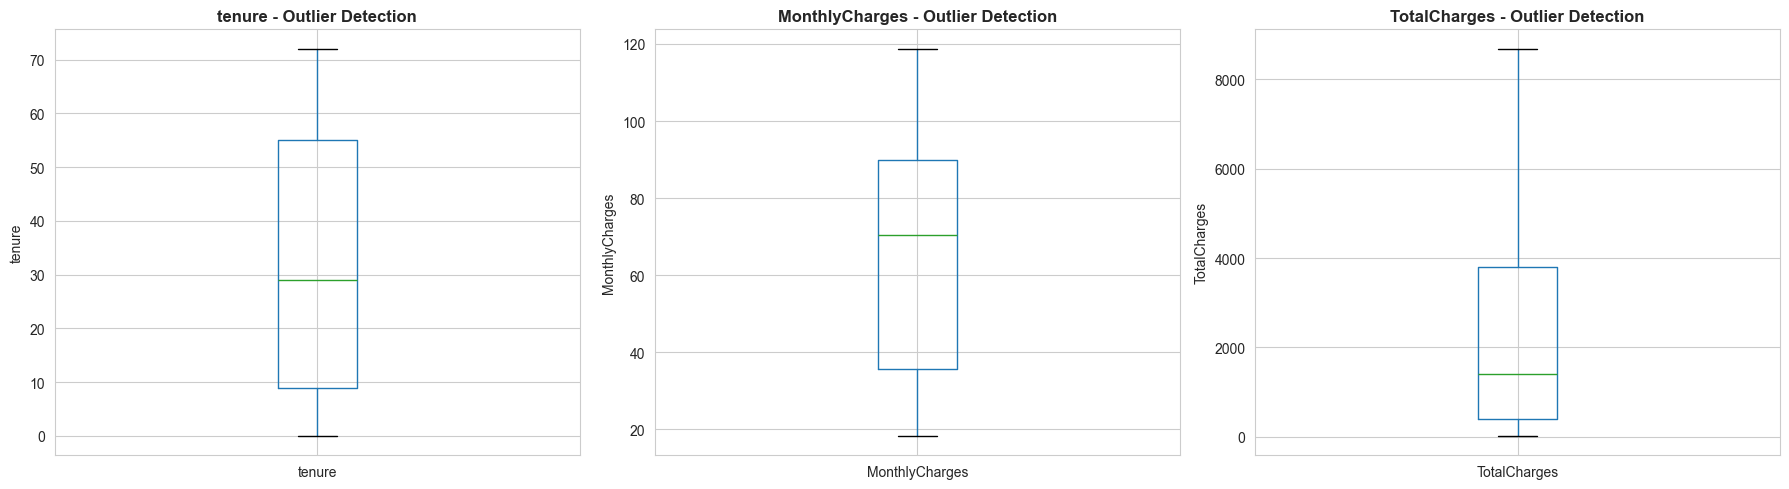


Note: Outliers may represent legitimate extreme values (e.g., very high-spending customers)
      Consider domain knowledge before removing outliers.


In [10]:
# Outlier detection using IQR method
print("=" * 80)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 80)

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
outliers_summary = {}

for col in numeric_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100

        outliers_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        print(f"\n{col}:")
        print(f"  Outliers: {outlier_count} ({outlier_pct:.2f}%)")
        print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numeric_cols):
    if col in df.columns:
        df.boxplot(column=col, ax=axes[idx])
        axes[idx].set_title(f'{col} - Outlier Detection', fontweight='bold')
        axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

print("\nNote: Outliers may represent legitimate extreme values (e.g., very high-spending customers)")
print("      Consider domain knowledge before removing outliers.")


CORRELATION ANALYSIS

Correlation with Churn (Numeric):
Churn_Numeric     1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199484
tenure           -0.352229
Name: Churn_Numeric, dtype: float64


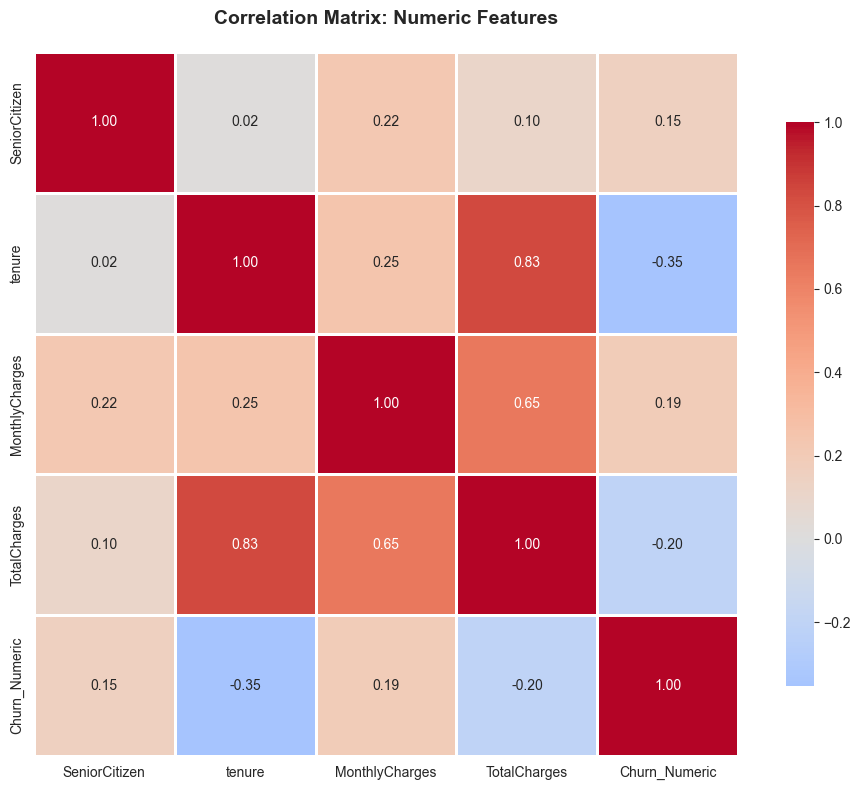


EDA Complete! Ready for feature engineering and modeling.


In [11]:
# Correlation analysis
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Prepare numeric features
numeric_df = df[["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]].copy()
numeric_df["Churn_Numeric"] = df["Churn"].map({"Yes": 1, "No": 0})

correlation_matrix = numeric_df.corr()
print("\nCorrelation with Churn (Numeric):")
print(correlation_matrix["Churn_Numeric"].sort_values(ascending=False))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix: Numeric Features", fontweight="bold", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nEDA Complete! Ready for feature engineering and modeling.")
